In [ ]:
pip install PyPortfolioOpt

In [ ]:
pip install yahoo-fin

In [ ]:
conda install matplotlib --force

In [ ]:
pip install requests_html

## The steps I will be following are the following:

1. Fetch the stock names recommended by Yahoo Finance.

2. Fetch all possible News Articles related to those companies.

3. Fetch all possible tweets related to those companies.

4. Combine all tweets and articles into two separate strings.

5. Perform sentiment analysis on the Tweets and News Articles.

6. According to that score, dictate whether the Analysts’ recommendations should be followed.

7. Send the final recommendations to the user via Facebook messenger.

In [1]:
import requests
import pandas as pd 
from yahoo_fin import stock_info as si 
from pandas_datareader import DataReader
import numpy as np

from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.sentiment.vader import SentimentIntensityAnalyzer

C:\Users\shinde.ni\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Understanding The Data
**As mentioned previously, the types of data that are going to be used are News Articles, Tweets, and Yahoo’s recommended stocks.**

The latter is something that is not really known. Yahoo Finance actually provides users with such information. The indicators provided, are the result of a thorough analysis conducted by the hundred of analysts they employ.

#### <b>The recommendation system consists of a scale.</b> 

> The scale can be observed above. The rating of a stock varies and can have a score of 1 (signaling a strong buy) up to 5 (signaling a strong sell).

> For the purpose of this analysis, the only values that are of importance are 1–1.5, 3, and 4.5–5. These are the scores, that signify the highest chance for an event to take place, and thus are the best indicators.

I have decided to use the S&P 500 for testing purposes. The following code can be used to import the data:

In [3]:
tic = si.get_stats('HINDUNILVR.NS')
tic

,Attribute,Value
0,Beta (5Y Monthly),0.07
1,52-Week Change 3,29.88%
2,S&P500 52-Week Change 3,7.99%
3,52 Week High 3,2614.30
4,52 Week Low 3,1701.05
5,50-Day Moving Average 3,2180.32
6,200-Day Moving Average 3,2151.32
7,Avg Vol (3 month) 3,7.31M
8,Avg Vol (10 day) 3,3.53M
9,Shares Outstanding 5,2.35B


In [2]:
tickers = si.tickers_sp500()
recommendations = []

for ticker in tickers:
    lhs_url = 'https://query2.finance.yahoo.com/v10/finance/quoteSummary/'
    rhs_url = '?formatted=true&crumb=swg7qs5y9UP&lang=en-US&region=US&' \
              'modules=upgradeDowngradeHistory,recommendationTrend,' \
              'financialData,earningsHistory,earningsTrend,industryTrend&' \
              'corsDomain=finance.yahoo.com'
              
    url =  lhs_url + ticker + rhs_url
    r = requests.get(url)
    if not r.ok:
        recommendation = 6
    try:
        result = r.json()['quoteSummary']['result'][0]
        recommendation =result['financialData']['recommendationMean']['fmt']
    except:
        recommendation = 6
    
    recommendations.append(recommendation)
    

In [ ]:
help(pd.DataFrame)

After performing some tweaking on the data, I created a pandas dataframe called “df” that includes two columns; “Company”; and “Recommendations”.

In [22]:
## Creating Data Frame from "tickers = Company name" & "recommendation"
df = pd.DataFrame(list(zip(tickers,recommendations)),columns=['Company', 'Recommendations'])
df.head()

,Company,Recommendations
0,A,2.40
1,AAL,3.30
2,AAP,2.30
3,AAPL,2.10
4,ABBV,1.90


In [23]:
## Both Data are Object Type
df.dtypes

Company            object
Recommendations    object
dtype: object

In [24]:
## Converting "Recommendations" into numeric type
## Discarding the stocks with assigned value “6”
## finally sort the dataframe in ascending recommendation order
df['Recommendations'] = pd.to_numeric(df['Recommendations'])
df = df[df.Recommendations != 6]
df.sort_values(by=['Recommendations'], ascending = True)

,Company,Recommendations
63,BIO,1.5
72,BSX,1.6
254,J,1.6
385,PWR,1.6
150,DXCM,1.6
...,...,...
1,AAL,3.3
60,BEN,3.4
154,ED,3.4
118,CTL,3.5


#### 501 initial stocks

In [25]:
df.dtypes

Company             object
Recommendations    float64
dtype: object

In [28]:
df.describe(include="all")

,Company,Recommendations
count,501,501.000000
unique,501,NaN
top,XRAY,NaN
freq,1,NaN
mean,NaN,2.367066
std,NaN,0.399115
min,NaN,1.500000
25%,NaN,2.100000
50%,NaN,2.300000
75%,NaN,2.600000


In [29]:
df.isnull().sum()

Company            0
Recommendations    0
dtype: int64

In [30]:
hold_df = df[df.Recommendations == 3]
buy_df = df[df.Recommendations <= 1.5]
sell_df = df[df.Recommendations >= 4.5]

df_list = [hold_df, buy_df, sell_df]
new_df = pd.concat(df_list)
new_df.reset_index(level=0, inplace=True)

In [39]:
new_df

,index,Company,Recommendations
0,84,CCL,3.0
1,95,CINF,3.0
2,98,CMA,3.0
3,111,COTY,3.0
4,112,CPB,3.0
5,136,DISCK,3.0
6,162,EQR,3.0
7,201,GL,3.0
8,228,HRL,3.0
9,242,INTC,3.0


### Out of the 501 initial stocks, only 22 have remained.

It is now time to fetch the News and Twitter feed. Once both feeds are successfully fetched, sentiment analysis for each stock will be individually conducted for each platform and then the two results will be added and divided by two.
So the final sentiment score will be calculated as follows:

> Final Score = (Twitter Sentiment Score + News Feed Sentiment Score) / 2

I will cover in detail the process of importing the news feed data and performing the sentiment analysis. As the process is not that intellectually intensive, I will not repeat the steps for twitter (they are more the less the same).

**To begin, I will be creating a list that is going to contain the tickers for the 22 stocks.**

In [40]:
tickers =[] 
  
for index, rows in new_df.iterrows(): 
    tickers.append(rows.Company) 

**finviz is going to be used to parse the news data into a Pandas dataframe.**

In [43]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\shinde.ni\AppData\Roaming\nltk_data...


True

In [44]:
finwiz_url = 'https://finviz.com/quote.ashx?t='

news_tables = {}

for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    response = urlopen(req)    
    html = BeautifulSoup(response)
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table
    
parsed_news = []

for file_name, news_table in news_tables.items():
    for x in news_table.findAll('tr'):
    
        text = x.a.get_text() 
        date_scrape = x.td.text.split()

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        ticker = file_name.split('_')[0]
        
        parsed_news.append([ticker, date, time, text])
        
vader = SentimentIntensityAnalyzer()

columns = ['ticker', 'date', 'time', 'headline']

parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.head()

,ticker,date,time,headline
0,CCL,2020-07-29,07:07AM,Stalled cruise industry targets repeat guests ...
1,CCL,2020-07-29,07:00AM,FOCUS-Stalled cruise industry targets repeat g...
2,CCL,2020-07-28,04:06PM,"Why Carnival Corporation, Royal Caribbean, and..."
3,CCL,2020-07-28,01:20PM,Understanding Carnival's Unusual Options Activity
4,CCL,2020-07-28,05:00AM,10 Cheap Stocks for Contrarians


Everything seems to be as expected. The only column we do not really need is “time”, and thus will be dropping it.

After thorough consideration, I have also decided to drop the “date” column. If on the other hand, you are interested in performing analysis for daily trades, I would recommend keeping the dates of the previous and current date of analysis.

The problem with the data is that in their current form, they can not be used by any model. Thus, I will be grouping the headlines for each company in one string, according to the company they are referring to.

In [47]:
parsed_and_scored_news = parsed_and_scored_news.groupby(['ticker'], as_index = False).\
                        agg({'headline': ''.join}, Inplace=True)

In [48]:
parsed_and_scored_news

,ticker,headline
0,BIO,Top Health Care Stocks for August 2020Bio-Rad ...
1,CCL,Stalled cruise industry targets repeat guests ...
2,CINF,Cincinnati Financial (CINF) Q2 2020 Earnings C...
3,CMA,Comerica Incorporated Just Beat EPS By 286%: H...
4,COTY,SHAREHOLDER ACTION ALERT: The Schall Law Firm ...
5,CPB,Top Consumer Staples Stocks for August 2020Gen...
6,DISCK,Discovery Asia Pacific Launches Asian Food Net...
7,EQR,Equity Residential Reports Second Quarter 2020...
8,GL,Globe Life Inc (GL) Q2 2020 Earnings Call Tran...
9,HRL,Chicago-based Fontanini Foods Announces Return...


**We now have 22 rows with two different columns. The “ticker” column, consisting of the company’s ticker, and “headline” which actually contains the entirety of news headlines related to the company.**

### Performing Sentiment Analysis
Everything is now set and the sentiment score can be assessed for both the tweets and news data. For the news headlines (and twits accordingly) the process is quite simple, and by using Vader it can be performed in the following way:

In [49]:
vader = SentimentIntensityAnalyzer()

scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

scores_df = pd.DataFrame(scores)

parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

In [50]:
parsed_and_scored_news

,ticker,headline,neg,neu,pos,compound
0,BIO,Top Health Care Stocks for August 2020Bio-Rad ...,0.021,0.895,0.084,0.9959
1,CCL,Stalled cruise industry targets repeat guests ...,0.084,0.815,0.102,0.9895
2,CINF,Cincinnati Financial (CINF) Q2 2020 Earnings C...,0.036,0.898,0.065,0.9793
3,CMA,Comerica Incorporated Just Beat EPS By 286%: H...,0.032,0.860,0.108,0.9965
4,COTY,SHAREHOLDER ACTION ALERT: The Schall Law Firm ...,0.061,0.784,0.155,0.9991
5,CPB,Top Consumer Staples Stocks for August 2020Gen...,0.030,0.858,0.112,0.9975
6,DISCK,Discovery Asia Pacific Launches Asian Food Net...,0.027,0.896,0.077,0.9918
7,EQR,Equity Residential Reports Second Quarter 2020...,0.013,0.883,0.104,0.9978
8,GL,Globe Life Inc (GL) Q2 2020 Earnings Call Tran...,0.015,0.888,0.097,0.9942
9,HRL,Chicago-based Fontanini Foods Announces Return...,0.043,0.839,0.118,0.9982


There you have it! The final sentiment scores for each stock can be seen in the column named “compound”. In other words, the column depicts the compound sentiment score for each entry. Now, according to whether the stock is designated as a “sell”, “buy”, or “hold”, __a decision can be made regarding the appropriate course of action.__

### For the shake of this project, I will be using the fbchat “Echo-Bot” example. The code for the bot is the following:

In [51]:
from fbchat import log, Client

# Subclass fbchat.Client and override required methods
class EchoBot(Client):
    def onMessage(self, author_id, message_object, thread_id, thread_type, **kwargs):
        self.markAsDelivered(thread_id, message_object.uid)
        self.markAsRead(thread_id)

        log.info("{} from {} in {}".format(message_object, thread_id, thread_type.name))

        # If you're not the author, echo
        if author_id != self.uid:
        
        self.send("message", thread_id=thread_id, thread_type=thread_type)


client = EchoBot("<username>", "<Password>")
client.listen()

IndentationError: expected an indented block (<ipython-input-51-37b116ce7eb7>, line 14)

The only change required to fit the project’s requirements is to create a small “for loop” that will iterate through the columns and send the appropriate message to the user.

##  I will be using the final stocks recommendations from above, and I will be building a model that is going to estimate the best way to partition our portfolio, in order to maximize the possible returns and at the same time minimize risk.

In order to select the **best possible asset distribution**, we will be relying on the **“Sharpe Ratio”** (see keywords).

The ratio describes how much excess return you receive for the extra volatility you endure for holding a riskier asset.

**It is generally accepted that a Sharp Ratio of “1” is considered optimal. “2” is really desirable, and “3” is extremely optimal.**

## Keywords
Having a precise plan in mind, we can now proceed by creating the model. Before doing so, I will be defining some simple financial terms that will be used throughout the analysis.

## Portfolio Variance
According to Investopedia:
> Portfolio variance is a measurement of risk, of how the aggregate actual returns of a set of securities making up a portfolio fluctuate over time. This portfolio variance statistic is calculated using the standard deviations of each security in the portfolio as well as the correlations of each security pair in the portfolio.

**In simpler terms, it is used as a measurement of risk.**

## Sharpe Ratio
The Sharp Ratio is essentially a tool with which you can find the best possible proportion to allocate to each stock in a portfolio.

## Covariance Matrix
In essence, the covariance matrix is used as a means of determining how much two random variables move together or vary. It is commonly used when comparing data samples from different sources. In this case scenario, it is the directional relationship between the price of two assets.

#### Performing The Analysis

In [52]:
from pandas_datareader import data as web
import pandas as pd
import numpy as np

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices


from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

For the shake of convenience, I will be creating a list called “assets” which will contain all of the values in the “tickers” array (the tickers of the final stocks that resulted from Part 1). 

I will be also setting the weights as 0.066 each.

In [69]:
assets = tickers

weights = np.array([0.066,0.066,0.066,0.066,0.066,0.066,0.066,0.066,0.066, 0.066, 0.066, 0.066, 0.066, 0.066, 0.066, 0.066, 0.066, 0.066, 0.066, 0.066, 0.066, 0.066, 0.066])
weights

array([0.066, 0.066, 0.066, 0.066, 0.066, 0.066, 0.066, 0.066, 0.066,
       0.066, 0.066, 0.066, 0.066, 0.066, 0.066, 0.066, 0.066, 0.066,
       0.066, 0.066, 0.066, 0.066, 0.066])

In [70]:
len(weights)

23

I will be setting the start date for the historical stocks-prices as the first of January, 2016. To import the prices, Yahoo Finance is going to be used.

In [55]:
stockStartDate = '2016-01-01'
today = datetime.today().strftime('%Y-%m-%d')

df = pd.DataFrame()

for stock in assets:
    df[stock] = web.DataReader(stock,data_source='yahoo',start=stockStartDate , end=today)['Adj Close']

In [56]:
df.head()

,CCL,CINF,CMA,COTY,CPB,DISCK,EQR,GL,HRL,INTC,...,MHK,NWSA,PAYX,PRU,RHI,UA,UAA,WFC,WRB,BIO
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-31,47.223583,52.023312,36.770660,22.293497,45.439041,25.219999,63.091995,54.942249,35.624722,30.541851,...,189.389999,12.445710,45.760334,68.338684,42.938049,80.610001,40.305000,46.392815,33.089043,138.660004
2016-01-04,46.980865,50.590199,36.419037,21.702024,44.669476,25.160000,61.785156,54.263004,35.237297,30.134039,...,186.449997,12.305975,44.600967,67.020760,42.027195,79.660004,39.830002,45.155331,32.212715,136.190002
2016-01-05,46.530144,50.889130,36.023472,21.693323,44.833763,25.270000,63.022415,54.927799,35.953571,29.992189,...,186.050003,11.896087,44.566353,66.794106,42.163815,80.150002,40.075001,45.138264,32.490726,136.179993
2016-01-06,46.391449,50.194550,35.610317,21.023563,44.755943,25.100000,62.427002,53.867973,36.075207,29.327276,...,182.119995,11.840195,43.934753,64.569595,41.043465,79.870003,39.935001,44.276295,32.079754,134.809998
2016-01-07,45.411961,49.077942,34.889492,20.414688,44.209629,24.320000,62.233673,52.962307,35.421997,28.227942,...,176.750000,11.570040,41.901543,61.942154,40.897728,78.000000,39.000000,43.013210,31.535822,131.990005


Everything seems to be imported correctly. It is now time to plot the different prices on a graph.

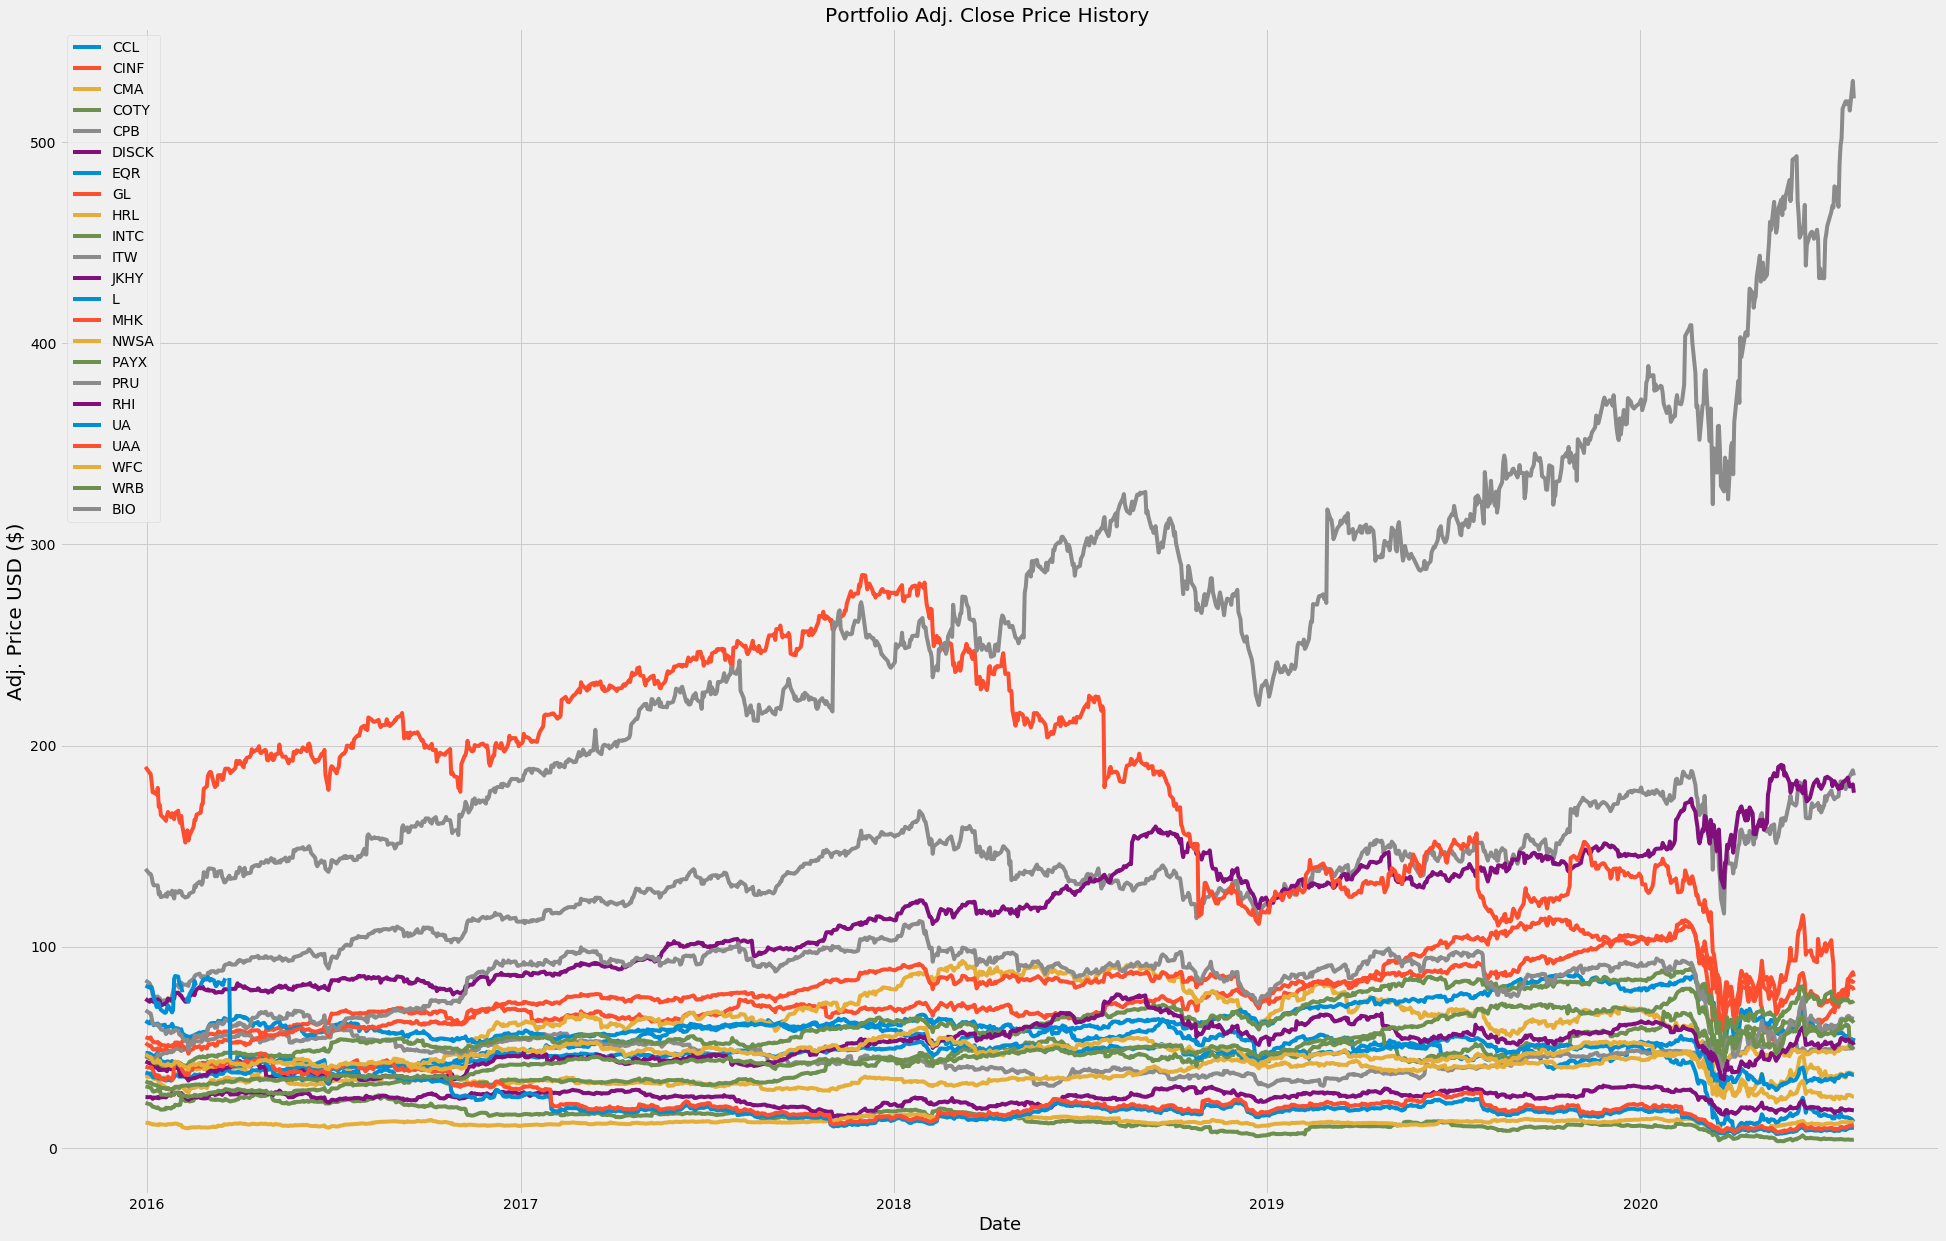

In [64]:
title = 'Portfolio Adj. Close Price History    '
my_stocks = df
plt.figure(figsize=(30,20)) 

for c in my_stocks.columns.values:
    plt.plot( my_stocks[c],  label=c)

plt.title(title)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Adj. Price USD ($)',fontsize=20)
plt.legend(my_stocks.columns.values, loc='upper left')
plt.show()

### Performing Financial Calculations
Our fictional portfolio is ready. It is now time to perform some sample calculations.
To start with, I will be calculating the daily simple returns by using the following formula:
> **(new_price/old_price) / old_price**

This can be done with the following line of code:

In [57]:
returns = df.pct_change()
returns

,CCL,CINF,CMA,COTY,CPB,DISCK,EQR,GL,HRL,INTC,...,MHK,NWSA,PAYX,PRU,RHI,UA,UAA,WFC,WRB,BIO
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-04,-0.005140,-0.027548,-0.009563,-0.026531,-0.016936,-0.002379,-0.020713,-0.012363,-0.010875,-0.013353,...,-0.015524,-0.011228,-0.025336,-0.019285,-0.021213,-0.011785,-0.011785,-0.026674,-0.026484,-0.017813
2016-01-05,-0.009594,0.005909,-0.010861,-0.000401,0.003678,0.004372,0.020025,0.012251,0.020327,-0.004707,...,-0.002145,-0.033308,-0.000776,-0.003382,0.003251,0.006151,0.006151,-0.000378,0.008630,-0.000073
2016-01-06,-0.002981,-0.013649,-0.011469,-0.030874,-0.001736,-0.006727,-0.009448,-0.019295,0.003383,-0.022170,...,-0.021123,-0.004698,-0.014172,-0.033304,-0.026571,-0.003493,-0.003493,-0.019096,-0.012649,-0.010060
2016-01-07,-0.021114,-0.022246,-0.020242,-0.028962,-0.012207,-0.031076,-0.003097,-0.016813,-0.018107,-0.037485,...,-0.029486,-0.022817,-0.046278,-0.040692,-0.003551,-0.023413,-0.023413,-0.028527,-0.016956,-0.020918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-22,-0.003292,0.026488,-0.015575,0.000000,-0.000203,0.005316,0.020707,0.006249,0.000603,0.005766,...,0.056031,0.007843,0.006818,0.007386,-0.000933,-0.002119,-0.005714,0.002290,-0.001406,0.002370
2020-07-23,-0.022457,0.030541,0.019367,0.012136,0.005878,0.010048,-0.015619,0.061311,0.015468,-0.010647,...,-0.002504,-0.010117,-0.008940,0.002444,0.005602,0.038217,0.041188,0.003427,0.008916,0.000096
2020-07-24,0.000000,0.006774,0.001338,-0.038369,-0.004634,-0.008901,-0.008937,0.000623,-0.005539,-0.162417,...,0.016137,-0.000786,-0.013393,-0.010970,-0.020798,0.005112,0.003680,-0.003416,-0.008372,-0.008783


### Lets now calculate the co-variance matrix.

In [65]:
cov_matrix_annual = returns.cov() * 252
cov_matrix_annual

,CCL,CINF,CMA,COTY,CPB,DISCK,EQR,GL,HRL,INTC,...,MHK,NWSA,PAYX,PRU,RHI,UA,UAA,WFC,WRB,BIO
CCL,0.291571,0.064621,0.127916,0.160071,0.003190,0.078895,0.058061,0.086569,0.010183,0.070304,...,0.115609,0.078046,0.061885,0.121600,0.083343,0.108593,0.111781,0.098358,0.066958,0.035127
CINF,0.064621,0.089595,0.066258,0.048800,0.018482,0.039935,0.040132,0.063132,0.023715,0.044177,...,0.047339,0.043123,0.054751,0.076763,0.048691,0.058150,0.061111,0.065475,0.060423,0.031462
CMA,0.127916,0.066258,0.159706,0.089809,0.006945,0.069387,0.044133,0.083623,0.010264,0.057264,...,0.090897,0.067365,0.053848,0.115956,0.076671,0.097007,0.097414,0.105331,0.062265,0.034583
COTY,0.160071,0.048800,0.089809,0.344186,0.017010,0.057172,0.047683,0.058566,0.014949,0.055602,...,0.091727,0.048682,0.040280,0.077627,0.056459,0.101114,0.104069,0.070326,0.045122,0.018754
CPB,0.003190,0.018482,0.006945,0.017010,0.072502,0.013220,0.017793,0.015216,0.030161,0.016104,...,0.008527,0.012678,0.016297,0.014085,0.008675,0.017615,0.017901,0.013201,0.017925,0.014154
DISCK,0.078895,0.039935,0.069387,0.057172,0.013220,0.126681,0.028137,0.049331,0.012907,0.040318,...,0.065804,0.051095,0.038754,0.067618,0.050496,0.075159,0.070790,0.054714,0.037659,0.019152
EQR,0.058061,0.040132,0.044133,0.047683,0.017793,0.028137,0.064737,0.040354,0.018658,0.031440,...,0.042493,0.032498,0.039013,0.047005,0.030124,0.044275,0.044830,0.042092,0.039765,0.020981
GL,0.086569,0.063132,0.083623,0.058566,0.015216,0.049331,0.040354,0.078836,0.019276,0.050659,...,0.061347,0.051979,0.053382,0.091509,0.055558,0.067247,0.071483,0.075707,0.056881,0.035084
HRL,0.010183,0.023715,0.010264,0.014949,0.030161,0.012907,0.018658,0.019276,0.054006,0.022172,...,0.011875,0.017473,0.021425,0.017871,0.013721,0.020246,0.021535,0.018531,0.022764,0.017975
INTC,0.070304,0.044177,0.057264,0.055602,0.016104,0.040318,0.031440,0.050659,0.022172,0.112148,...,0.049976,0.043925,0.050588,0.066016,0.049104,0.054567,0.057657,0.053186,0.042150,0.039587


The portfolio variance is another useful measurement. The formula to calculate it is quite simple and can be incorporated in python as follows:

In [74]:
port_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
print("Port Variance :", port_variance)

Port Variance : 0.1258363208821156


Finally, it is crucial that we calculate the volatility (square root of the variance), and the portfolio annual simple return.

In [75]:
port_volatility = np.sqrt(port_variance)
portfolioSimpleAnnualReturn = np.sum(returns.mean()*weights) * 252

print("Port Volatility :", port_volatility)
print("Simple Annual Return :", portfolioSimpleAnnualReturn)

Port Volatility : 0.35473415522347945
Simple Annual Return : 0.07224328518210248


At the stage, three measurements are of importance for this model:
>**1. Expected Annual Return**

>**2. Annual Volatility (Risk)**

>**3. Annual Variance**

In [76]:
percent_var = str(round(port_variance, 2) * 100) + '%'
percent_vols = str(round(port_volatility, 2) * 100) + '%'
percent_ret = str(round(portfolioSimpleAnnualReturn, 2)*100)+'%'
print("Expected annual return : "+ percent_ret)
print('Annual volatility/standard deviation/risk : '+percent_vols)
print('Annual variance : '+percent_var)

Expected annual return : 7.000000000000001%
Annual volatility/standard deviation/risk : 35.0%
Annual variance : 13.0%


It appears that the **annual return is at 6%** and the **risk is 23%**. 
According to most investors’ standards, this would certainly not be desirable. 

This is where portfolio optimization comes in.

### Portfolio Optimization
Thankfully, there is a library called “pypfopt” that can automate the entire process on our behalf.

In [77]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

To calculate the expected returns and annualized sample variance matrix of daily returns, only two lines of code are needed.

In [78]:
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df) 

### It is now finally time to optimize the portfolio for maximum Sharpe ration.

In [79]:
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe() 
cleaned_weights = ef.clean_weights() 
print(cleaned_weights) 
ef.portfolio_performance(verbose=True)

OrderedDict([('CCL', 0.0), ('CINF', 0.0), ('CMA', 0.0), ('COTY', 0.0), ('CPB', 0.0), ('DISCK', 0.0), ('EQR', 0.0), ('GL', 0.0), ('HRL', 0.0), ('INTC', 0.0), ('ITW', 0.11302), ('JKHY', 0.36826), ('L', 0.0), ('MHK', 0.0), ('NWSA', 0.0), ('PAYX', 0.0), ('PRU', 0.0), ('RHI', 0.0), ('UA', 0.0), ('UAA', 0.0), ('WFC', 0.0), ('WRB', 0.0), ('BIO', 0.51872)])
Expected annual return: 27.5%
Annual volatility: 22.0%
Sharpe Ratio: 1.16


(0.2751431809025624, 0.2198467878435258, 1.1605499602939777)

Voila! The **expected annual return has now increased to 21.1%** and the **risk has decreased to 17.9%**.

We will now be setting our budget of $15,000 and will be asking the model to tell us how to allocate it effectively (according to current prices).

In [80]:
latest_prices = get_latest_prices(df)
weights = cleaned_weights 
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=15000)
allocation, leftover = da.lp_portfolio()
print("Discrete allocation:", allocation)

Discrete allocation: {'COTY': 3.0, 'DISCK': 1.0, 'ITW': 9.0, 'JKHY': 31.0, 'BIO': 15.0}


The model has now completed. It appears, that the best way to partition the portfolio is by owning:

In [109]:
print("QTY".ljust(5),"Name of Stock")

for key in allocation:
    print(str(allocation[key]).ljust(5), key)

QTY   Name of Stock
3.0   COTY
1.0   DISCK
9.0   ITW
31.0  JKHY
15.0  BIO
